# Risk Aversion

In [1]:
import numpy as np
from matplotlib import pyplot as plt

This notebook does three things: 
1. Learn how to define a utility function
2. Learn how to deal with risk (model it)
3. Learn how to compute a willingness to pay
4. Learn how to infer risk aversion from a multiple price list (MPL)

## Utility functions

We will setup a CRRA and CARA utility functions

In [2]:
def crra(w,gamma):
    if gamma==1.0:
        return np.log(w)
    else :
        return (w**(1-gamma)-1.0)/(1.0-gamma)

def cara(w,alpha):
    return -(1.0/alpha)*np.exp(-alpha*w)

Let's also define the inverses of these functions

In [3]:
def invcrra(u,gamma):
    if sigma==1.0:
        return np.exp(w)
    else :
        return (u*(1.0-gamma)+1.0)**(1.0/(1.0-gamma))

def invcara(u,alpha):
    return -np.log(-u*alpha)/alpha 

Let's look what these functions look like varying parameters

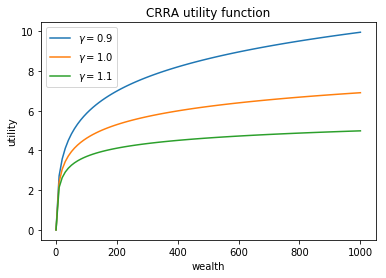

In [4]:
ws = np.linspace(1,1e3,100)
gammas = [0.9,1.0,1.1]
plt.figure()
for gamma in gammas:
    plt.plot(ws,crra(ws,gamma),label='$\\gamma=$'+str(gamma))
plt.xlabel('wealth')
plt.ylabel('utility')
plt.title('CRRA utility function')
plt.legend()
plt.savefig('crra_plot.png')

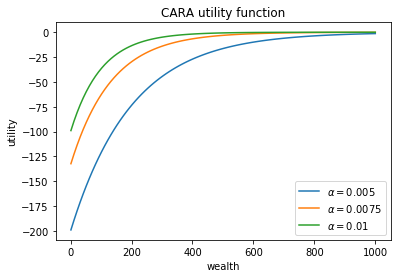

In [5]:
alphas = [0.005,0.0075,0.01]
plt.figure()
for alpha in alphas:
    plt.plot(ws,cara(ws,alpha),label='$\\alpha=$'+str(alpha))
plt.xlabel('wealth')
plt.ylabel('utility')
plt.title('CARA utility function')
plt.legend()
plt.savefig('cara_plot.png')

## Dealing with risk

In [6]:
from scipy.stats import norm, lognorm, chi2

### draws

(array([  3.,  13.,  55., 151., 247., 276., 164.,  64.,  25.,   2.]),
 array([-3.47946872, -2.79812668, -2.11678465, -1.43544262, -0.75410058,
        -0.07275855,  0.60858349,  1.28992552,  1.97126756,  2.65260959,
         3.33395163]),
 <a list of 10 Patch objects>)

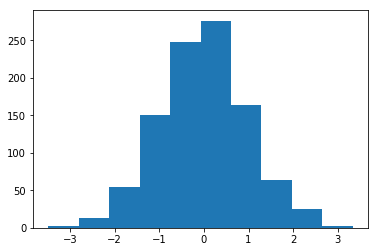

In [7]:
x = norm(0,1).rvs(1000)
plt.hist(x)

### cumulative distibution function (cdf) and probability density function (pdf)

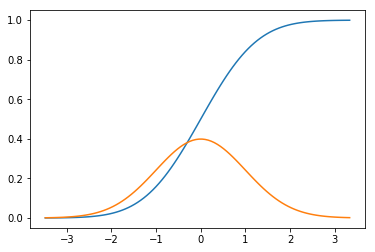

In [8]:
x = np.linspace(np.min(x),np.max(x),100)
plt.figure()
plt.plot(x,norm(0,1).cdf(x))
plt.plot(x,norm(0,1).pdf(x))


### inverse cdf

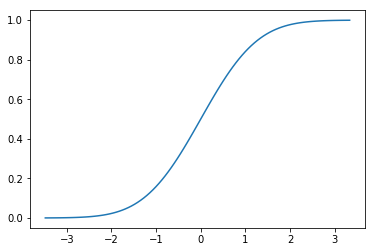

In [9]:
p = norm(0,1).cdf(x)
plt.figure()
plt.plot(norm(0,1).ppf(p),p)

### Expected utility (using simulation)

In [10]:
S = 10000
sig = 1000
eps = norm(0,sig).rvs(S)
wealth = 50e3
eu = np.mean([crra(wealth+e,gamma) for e in eps])
eu

6.6107289774835545

In [11]:
def eucrra(wealth,gamma,eps):
    return np.mean([crra(wealth+e,gamma) for e in eps])

Text(0,0.5,'expected utility')

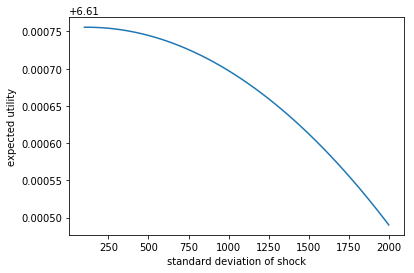

In [12]:
sigs = np.linspace(100.0,2000.0,100)
eus = []
eps = norm(0,1).rvs(S)
for sig in sigs:
    eus.append(eucrra(wealth,gamma,sig*eps))
plt.figure()
plt.plot(sigs,eus)
plt.xlabel('standard deviation of shock')
plt.ylabel('expected utility')

## Willingness to pay

We can easily find the willingness to pay by solving: 
$$ u(w-\pi) - Eu(w+\epsilon) = 0$$

Some algorithms allow us to do that. One such algorithm is Brent's method which uses simple bi-section. See for example: https://en.wikipedia.org/wiki/Brent%27s_method

In [13]:
def solve(pi,wealth,gamma,eps):
    u = crra(wealth-pi,gamma)
    eu = eucrra(wealth,gamma,eps)
    return eu-u 

In [14]:
from scipy.optimize import brentq
S = 10000
sig = 1000.0
eps = norm(0,1).rvs(S)
wealth = 10e3
brentq(solve, 0.0, 0.99*wealth,args=(wealth,gamma,sig*eps))


64.86699411797197

The consumer is willing to pay this amount to avoid the risk. We can do this for varying levels of risk and compare to the Arrow-Pratt approximation. 

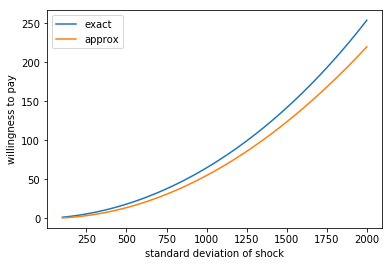

In [15]:
pis = []
apis = []
for sig in sigs:
    pis.append(brentq(solve, 0.0, wealth-1.0,args=(wealth,gamma,sig*eps)))
    apis.append(0.5*(sig**2)*gamma/wealth)
plt.figure()
plt.plot(sigs,pis,label='exact')
plt.plot(sigs,apis,label='approx')
plt.xlabel('standard deviation of shock')
plt.ylabel('willingness to pay')
plt.legend()

The standard approximation, $\pi = \frac{1}{2}\sigma^2A(w)$ is not good for large shocks. For CRRA, $A(w) = \frac{\gamma}{w}$. 

## Multiple Price List and Risk Aversion

To elicit preferences, MPLs are often used. Let's consider the following MPL from Holt and Laury (2002) (https://www.aeaweb.org/articles?id=10.1257/000282802762024700).  

In [16]:
import pandas as pd
MPL = pd.DataFrame(data=None,columns=['p(A)','w(A,0)','1-p(A)','w(A,1)','p(B)','w(B,0)','1-p(B)','w(B,1)'])

In [17]:
MPL['p(A)'] = [0.1+0.1*s for s in range(0,10)]
MPL['1-p(A)'] = 1 - MPL['p(A)']
MPL['w(A,0)'] = 2.0
MPL['w(A,1)'] = 1.6

In [18]:
MPL['p(B)']   = MPL['p(A)']
MPL['1-p(B)']   = 1.0-MPL['p(B)']
MPL['w(B,0)'] = 3.85
MPL['w(B,1)'] = 0.1

Let's first compute the expected value of each lottery

In [19]:
MPL['EA'] = MPL['p(A)']*MPL['w(A,0)']+MPL['1-p(A)']*MPL['w(A,1)'] 
MPL['EB'] = MPL['p(B)']*MPL['w(B,0)']+MPL['1-p(B)']*MPL['w(B,1)'] 


Let's use a CRRA on this to see how to make an optimal choice


In [20]:
gamma = 0.1
MPL['EUA'] = MPL.apply(lambda x: x['p(A)']*crra(x['w(A,0)'],gamma) 
                       + x['1-p(A)']*crra(x['w(A,1)'],gamma), axis=1)
MPL['EUB'] = MPL.apply(lambda x: x['p(B)']*crra(x['w(B,0)'],gamma) 
                       + x['1-p(B)']*crra(x['w(B,1)'],gamma), axis=1)


In [21]:
MPL

,p(A),"w(A,0)",1-p(A),"w(A,1)",p(B),"w(B,0)",1-p(B),"w(B,1)",EA,EB,EUA,EUB
0,0.1,2.0,0.9,1.6,0.1,3.85,0.9,0.1,1.64,0.475,0.622769,-0.611390
1,0.2,2.0,0.8,1.6,0.2,3.85,0.8,0.1,1.68,0.850,0.660494,-0.251550
2,0.3,2.0,0.7,1.6,0.3,3.85,0.7,0.1,1.72,1.225,0.698219,0.108290
3,0.4,2.0,0.6,1.6,0.4,3.85,0.6,0.1,1.76,1.600,0.735944,0.468130
4,0.5,2.0,0.5,1.6,0.5,3.85,0.5,0.1,1.80,1.975,0.773670,0.827971
5,0.6,2.0,0.4,1.6,0.6,3.85,0.4,0.1,1.84,2.350,0.811395,1.187811
6,0.7,2.0,0.3,1.6,0.7,3.85,0.3,0.1,1.88,2.725,0.849120,1.547651
7,0.8,2.0,0.2,1.6,0.8,3.85,0.2,0.1,1.92,3.100,0.886845,1.907491
8,0.9,2.0,0.1,1.6,0.9,3.85,0.1,0.1,1.96,3.475,0.924570,2.267331
9,1.0,2.0,0.0,1.6,1.0,3.85,0.0,0.1,2.00,3.850,0.962296,2.627172


We see that someone with $\gamma=0.25$ should switch at lotery 5 (starting from zero)

So we could generate data for $N$ respondent makers with different $\gamma$, record when they should switch

In [22]:
gammas = np.exp(norm(-2,1.0).rvs(S))

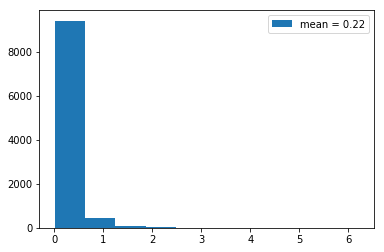

In [23]:
plt.hist(gammas,label='mean = '+str(np.mean(gammas).round(2)))
plt.legend()

In [24]:
data = pd.DataFrame(data=None,columns=['gamma','switch'])
data['gamma'] = gammas
data.describe()

,gamma
count,10000.000000
mean,0.221215
std,0.288553
min,0.001763
25%,0.068996
50%,0.136180
75%,0.262407
max,6.219342


In [25]:
def switch(row):
    gamma = row['gamma']
    choice = 0
    for i in MPL.index:
        pa  = MPL.loc[i,'p(A)']
        pb  = MPL.loc[i,'p(B)']
        
        ua0 = crra(MPL.loc[i,'w(A,0)'],gamma) 
        ua1 = crra(MPL.loc[i,'w(A,1)'],gamma)
        ub0 = crra(MPL.loc[i,'w(B,0)'],gamma) 
        ub1 = crra(MPL.loc[i,'w(B,1)'],gamma)
        
        eua = pa*ua0 + (1.0-pa)*ua1
        eub = pa*ub0 + (1.0-pb)*ub1

        if eua <= eub:
            choice = i
            break
    if (choice == np.nan):
        choice = np.max(MPL.index.values) 
    return choice
        
        

In [26]:
data['switch'] = data.apply(switch, axis=1)

In [27]:
data['switch'].value_counts().sort_index()

4    5286
5    3436
6     772
7     263
8     138
9     105
Name: switch, dtype: int64

In [28]:
def stats(x):
    d = {}
    d['min'] = x['gamma'].min()
    d['max'] = x['gamma'].max()
    d['mean'] = x['gamma'].mean()
    d['count'] = x['gamma'].count()
    return pd.Series(d, index=['min', 'max', 'mean', 'count'])
table = data.groupby(by=['switch']).apply(stats)


In [29]:
table.round(3)

,min,max,mean,count
switch,,,,
4,0.002,0.146,0.075,5286.0
5,0.146,0.411,0.244,3436.0
6,0.412,0.675,0.512,772.0
7,0.676,0.969,0.805,263.0
8,0.973,1.361,1.128,138.0
9,1.370,6.219,2.055,105.0


Now turn things around, suppose we give you only a dataset with the choices but not the gammas. Can you find the lower and upper bound of gamma for each respondent based on these choices?

For the MPL, augment it by finding bounds on gamma for each switch. Let's put back the MPL

In [30]:
MPL

,p(A),"w(A,0)",1-p(A),"w(A,1)",p(B),"w(B,0)",1-p(B),"w(B,1)",EA,EB,EUA,EUB
0,0.1,2.0,0.9,1.6,0.1,3.85,0.9,0.1,1.64,0.475,0.622769,-0.611390
1,0.2,2.0,0.8,1.6,0.2,3.85,0.8,0.1,1.68,0.850,0.660494,-0.251550
2,0.3,2.0,0.7,1.6,0.3,3.85,0.7,0.1,1.72,1.225,0.698219,0.108290
3,0.4,2.0,0.6,1.6,0.4,3.85,0.6,0.1,1.76,1.600,0.735944,0.468130
4,0.5,2.0,0.5,1.6,0.5,3.85,0.5,0.1,1.80,1.975,0.773670,0.827971
5,0.6,2.0,0.4,1.6,0.6,3.85,0.4,0.1,1.84,2.350,0.811395,1.187811
6,0.7,2.0,0.3,1.6,0.7,3.85,0.3,0.1,1.88,2.725,0.849120,1.547651
7,0.8,2.0,0.2,1.6,0.8,3.85,0.2,0.1,1.92,3.100,0.886845,1.907491
8,0.9,2.0,0.1,1.6,0.9,3.85,0.1,0.1,1.96,3.475,0.924570,2.267331
9,1.0,2.0,0.0,1.6,1.0,3.85,0.0,0.1,2.00,3.850,0.962296,2.627172


If someone switches right away at zero. It could be that he is extremely risk loving, $\gamma=-\infty$ but we can find $\gamma$ such that $EU(A)=EU(B)$ in that first line. 

In [31]:
def gap(gamma,prob,wa,wb):
    eua = prob*crra(wa[0],gamma) + (1-prob)*crra(wa[1],gamma)
    eub = prob*crra(wb[0],gamma) + (1-prob)*crra(wb[1],gamma)
    return eua - eub

In [32]:
brentq(gap,-5.0,5.0,args=(0.1,[2.0,1.6],[3.85,0.1]))

-1.7128201932416405

This tells us that if someone switches at zero, has has $\gamma$ in interval $(-\infty,-1.713)$.

Let's find all the upperbounds

In [33]:
nchoice = np.max(MPL.index.values)
for i in range(0,nchoice):
    p = MPL.loc[i,'p(A)']
    wa = [MPL.loc[i,'w(A,0)'],MPL.loc[i,'w(A,1)']]
    wb = [MPL.loc[i,'w(B,0)'],MPL.loc[i,'w(B,1)']]
    MPL.loc[i,'upper'] = brentq(gap,-5.0,5.0,args=(p,wa,wb))
MPL.loc[nchoice,'upper'] = np.inf

Let's add the lower bounds

In [34]:
MPL.loc[0,'lower'] = -np.inf
for i in range(1,nchoice+1):
    MPL.loc[i,'lower'] = MPL.loc[i-1,'upper']

In [35]:
MPL[['lower','upper']]

,lower,upper
0,-inf,-1.712820
1,-1.712820,-0.946837
2,-0.946837,-0.486575
3,-0.486575,-0.142632
4,-0.142632,0.146363
5,0.146363,0.411456
6,0.411456,0.676180
7,0.676180,0.970581
8,0.970581,1.368391
9,1.368391,inf


We can now put bounds on $\gamma$ for our respondents

In [36]:
data['gamma_min'] = data.apply(lambda x: MPL.loc[x['switch'],'lower'],axis=1)
data['gamma_max'] = data.apply(lambda x: MPL.loc[x['switch'],'upper'],axis=1)

We can check all in the interval

In [37]:
data['check'] = (data['gamma']>=data['gamma_min']) & (data['gamma']<=data['gamma_max'])

In [38]:
np.sum(data['check']==False)

0

You can try this on actual data. You can also construct an econometric model to obtain point predictions, given some distribution (say log normal). 

Some issues with MPLs:
* noise (what is folks do this with noise...)
* incoherent answers (what if they switch twice)?
* framing (where we place end points)
* stakes
* incentives or not